In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [24]:
device = 'cuda'

In [25]:
torch.cuda.is_available()

True

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)


In [27]:
batch_size = 128
epochs = 10
learning_rate = 3e-4
patch_size = 4
num_classes = 10
image_size = 32
channels = 3
embed_dim = 256
num_heads = 8
depth = 6
mlp_dim = 512
drop_rate = 0.1


In [28]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5),(0.5))
# ])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))

])

In [29]:
train_dataset = datasets.CIFAR10(root='data',
                                 train=False,
                                 download=True,
                                 transform=transform)


100%|██████████| 170M/170M [02:46<00:00, 1.03MB/s]   


Extracting data/cifar-10-python.tar.gz to data


In [30]:
test_dataset = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified


In [31]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [32]:
print(f"Length of train_loader: {len(train_loader)} batches of {batch_size}...")
print(f"Length of test_loader: {len(test_loader)} batches of {batch_size}...")

Length of train_loader: 79 batches of 128...
Length of test_loader: 79 batches of 128...


In [33]:
class PatchEmbedding(nn.Module):

    def __init__(self, img_size, patch_size,
                 in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels=in_channels,
                              out_channels=embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x:torch.Tensor):
        B = x.size(0)
        x = self.proj(x)  # (B, E, H/P, W/P)
        x = x.flatten(2).transpose(1,2)  # (B, N, E)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        return x


In [34]:
class MLP(nn.Module):

    def __init__(self, in_features, hidden_features, drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, 
                            out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x:torch.tensor):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x
    

In [35]:
class TransformerEncoderLayer(nn.Module):
    
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, 
                                          dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x
    

In [36]:
class VisionTransformer(nn.Module):

    def __init__(self, img_size, patch_size,in_channels,num_classes,
                 embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self,x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x)
        cls_token = x[:,0]
        return self.head(cls_token)
        


In [37]:
model = VisionTransformer(
    image_size, patch_size, channels, num_classes,
    embed_dim, depth, num_heads, mlp_dim, drop_rate
).to(device)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate)

In [39]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0

    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

        

In [40]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.inference_mode():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()
    return correct / len(loader.dataset)

In [41]:
from tqdm.auto import tqdm

In [42]:
train_accuracies, test_accuracies = [],[]

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch: {epoch+1}/{epochs}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, Train loss: 2.0352, Train acc: 0.2515, Test acc: 0.3107
Epoch: 2/10, Train loss: 1.7929, Train acc: 0.3528, Test acc: 0.3816
Epoch: 3/10, Train loss: 1.6601, Train acc: 0.4050, Test acc: 0.4354
Epoch: 4/10, Train loss: 1.5510, Train acc: 0.4479, Test acc: 0.4607
Epoch: 5/10, Train loss: 1.4427, Train acc: 0.4831, Test acc: 0.5014
Epoch: 6/10, Train loss: 1.3540, Train acc: 0.5145, Test acc: 0.5661
Epoch: 7/10, Train loss: 1.2802, Train acc: 0.5416, Test acc: 0.6040
Epoch: 8/10, Train loss: 1.2115, Train acc: 0.5642, Test acc: 0.6327
Epoch: 9/10, Train loss: 1.1231, Train acc: 0.5972, Test acc: 0.6821
Epoch: 10/10, Train loss: 1.0310, Train acc: 0.6314, Test acc: 0.7001


In [ ]:
# Epoch: 1/10, Train loss: 1.7292, Train acc: 0.3777, Test acc: 0.4190
# Epoch: 2/10, Train loss: 1.5929, Train acc: 0.4240, Test acc: 0.4714
# Epoch: 3/10, Train loss: 1.4758, Train acc: 0.4770, Test acc: 0.5147
# Epoch: 4/10, Train loss: 1.3904, Train acc: 0.5004, Test acc: 0.5314
# Epoch: 5/10, Train loss: 1.3209, Train acc: 0.5282, Test acc: 0.5810
# Epoch: 6/10, Train loss: 1.2469, Train acc: 0.5530, Test acc: 0.6308
# Epoch: 7/10, Train loss: 1.1482, Train acc: 0.5860, Test acc: 0.6618
# Epoch: 8/10, Train loss: 1.0698, Train acc: 0.6164, Test acc: 0.6803
# Epoch: 9/10, Train loss: 0.9859, Train acc: 0.6474, Test acc: 0.7253
# Epoch: 10/10, Train loss: 0.9050, Train acc: 0.6745, Test acc: 0.7348

In [43]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [58]:
import random

def predict_and_plot_grid(model, dataset, classes, grid_size):
    model.eval() 
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9,9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1) 
            img, true_label = dataset[idx]      
            input_tensor = img.unsqueeze(dim=0).to(device)   
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5  #denormalize
            npimg = img.cpu().numpy()
            axes[i,j].imshow(np.transpose(npimg, (1,2,0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"
            axes[i,j].set_title(f"Tr: {classes[true_label]}\n, Pr: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i,j].axis('off')
    plt.tight_layout()
    plt.show()


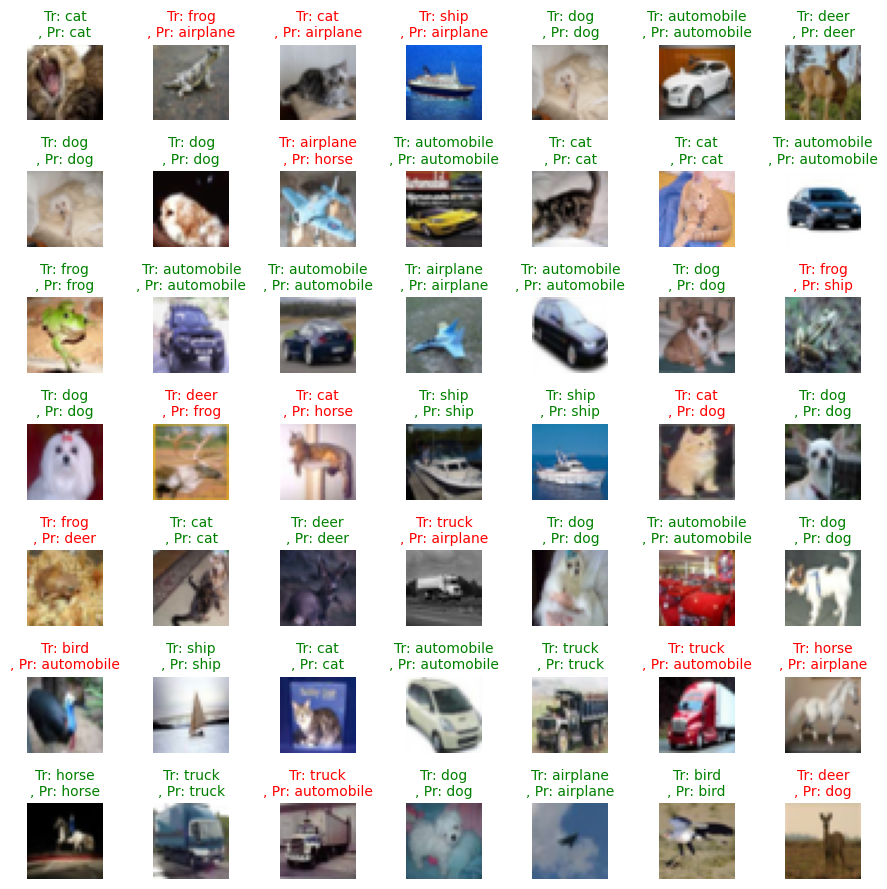

In [59]:
predict_and_plot_grid(model, test_dataset, classes=train_dataset.classes, grid_size=7)